# VIT Implementation from scratch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1DutMIWaT2KoptgNSKQt2YxBjcaBm_iZd?usp=sharing)


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Basic Architecture
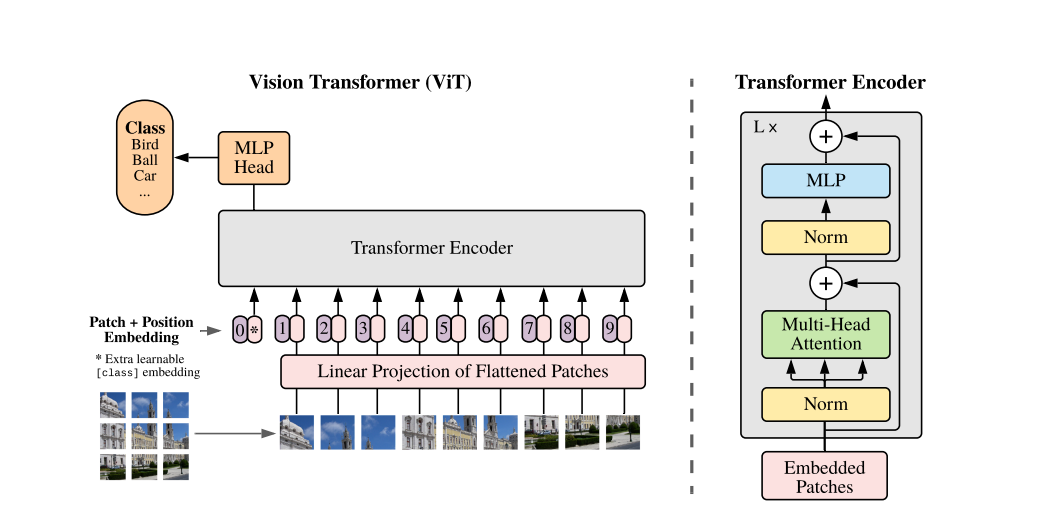

In [15]:
import torch
import numpy as np
import torch.nn as nn
import math

### Patchify without Conv

In [16]:
class Patchify(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.patch_size = config['patch_size']
    self.num_channels = config['num_channels']
    self.hidden_size = config['hidden_size']

    # Each patch has dimension = C * P^2
    patch_dim = self.num_channels * (self.patch_size ** 2)

    self.projection = nn.Linear(patch_dim, self.hidden_size)


  def forward(self,x):
    b,c,h,w = x.shape
    if h%self.patch_size != 0 or w%self.patch_size != 0:
      raise ValueError("Wrong Patch size or image dim, fix that")
    p = self.patch_size
    x = x.view(b, c, h / p, p, w / p, p)
    x = x.reshape(b, -1, c * p * p)
    x = self.proj(x)                         # (b, num_patches, hidden_size)

    return x


### Patchify with conv

faster process, more usable in other implementations like in the paper, huggingface transformers, etc.

In [17]:
class Patchify_Conv(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.patch_size = config['patch_size']
    self.num_channels = config['num_channels']
    self.hidden_size = config['hidden_size']
    self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

  def forward(self, x):
    b,c,h,w = x.shape
    if h%self.patch_size != 0 or w%self.patch_size != 0:
      raise ValueError("Wrong Patch size or image dim, fix that")
    x = self.projection(x)
    x = x.flatten(2).transpose(1, 2)

    return x




### Patch Embedding and Position Embedding


In [18]:
class ViTPatchEmbed(nn.Module):

  def __init__(self, config):
    super().__init__()
    if config['patchify_method'] == "conv":
      self.patchify = Patchify_Conv(config)
    else:
      self.patchify = Patchify(config)
    self.num_patches = (config["image_size"] // config["patch_size"]) ** 2
    self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
    self.position_embeddings = nn.Parameter(torch.randn(1, self.num_patches + 1, config["hidden_size"]))
    self.dropout = nn.Dropout(config["hidden_dropout_prob"])

  def forward(self, x):
    x = self.patchify(x)
    b, n, _ = x.shape
    cls_tokens = self.cls_token.expand(b, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x += self.position_embeddings
    x = self.dropout(x)

    return x

### Attention Head

In [19]:
class ViTAttentionHead(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.hidden_size = config['hidden_size']
    self.attn_head_size = config['hidden_size'] // config['num_attention_heads']
    self.bias = config['bias'] # added just for the sake of experimentation
    self.w_query = nn.Linear(self.hidden_size, self.attn_head_size, bias=self.bias)
    self.w_key = nn.Linear(self.hidden_size, self.attn_head_size, bias=self.bias)
    self.w_value = nn.Linear(self.hidden_size, self.attn_head_size, bias=self.bias)
    self.dropout = nn.Dropout(config['hidden_dropout_prob'])


  def forward(self, x):
    q = self.w_query(x)
    k = self.w_key(x)
    v = self.w_value(x)

    attn_matrix = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.attn_head_size)
    attn_matrix = torch.softmax(attn_matrix, dim=-1)
    attn_matrix = self.dropout(attn_matrix)
    attn_output = torch.matmul(attn_matrix, v)

    return attn_matrix, attn_output

### Multi Head Attention




In [20]:
class ViTMultiHeadAttention(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.hidden_size = config["hidden_size"]
    self.num_attention_heads = config["num_attention_heads"]
    self.attention_head_size = self.hidden_size // self.num_attention_heads
    self.all_head_size = self.num_attention_heads * self.attention_head_size
    self.heads = nn.ModuleList([])
    for _ in range(self.num_attention_heads):
        head = ViTAttentionHead(config)
        self.heads.append(head)
    self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
    self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

  def forward(self, x, output_attentions=False):
      attention_outputs = [head(x) for head in self.heads]  # list of tuples (attn_matrix, attn_output)
      attention_output = torch.cat([attn_output for _, attn_output in attention_outputs], dim=-1)
      attention_output = self.output_projection(attention_output)
      attention_output = self.output_dropout(attention_output)
      attention_probs = torch.stack([attn_matrix for attn_matrix, _ in attention_outputs], dim=1)

      return attention_output, attention_probs

### Transformer Encoder

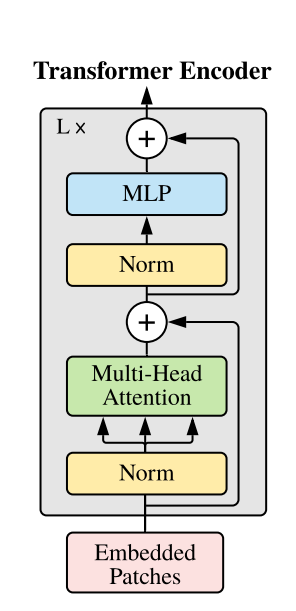



#### MLP

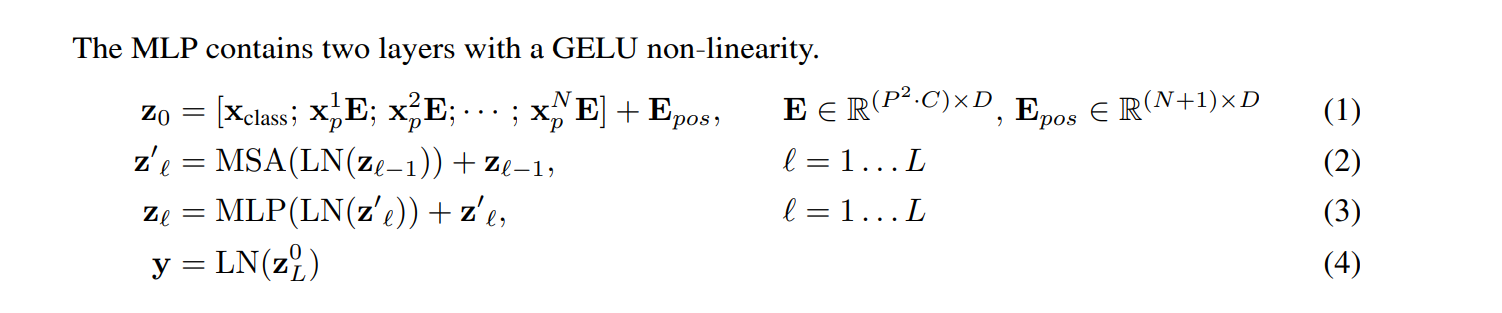

In [21]:
class MLP(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.hidden_size = config['hidden_size']
    self.intermediate_size = config['intermediate_size']
    self.dropout_prob = config['hidden_dropout_prob']
    self.layer1 = nn.Linear(self.hidden_size, self.intermediate_size)
    self.activation = nn.GELU()
    self.layer2 = nn.Linear(self.intermediate_size, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_prob)

  def forward(self, x):
    x = self.layer1(x)
    x = self.activation(x)
    x = self.layer2(x)
    x = self.dropout(x)

    return x

In [22]:
class ViTTransformerBlock(nn.Module):

  def __init__(self,config):
    super().__init__()
    self.attention = ViTMultiHeadAttention(config)
    self.ln_1 = nn.LayerNorm(config["hidden_size"])
    self.mlp = MLP(config)
    self.ln_2 = nn.LayerNorm(config["hidden_size"])

  def forward(self, x):
    attn_output, attn_probs = self.attention(self.ln_1(x))
    x = x + attn_output
    mlp_output = self.mlp(self.ln_2(x))
    x = x + mlp_output
    return x, attn_probs


In [23]:
class ViTEncoder(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.blocks = nn.ModuleList([])
    for _ in range(config["num_hidden_layers"]):
      block = ViTTransformerBlock(config)
      self.blocks.append(block)

  def forward(self, x):
    all_attentions = []
    for block in self.blocks:
      x, attn_probs = block(x)
      all_attentions.append(attn_probs)
    return x, all_attentions

In [24]:
class ViT_cifar10(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.image_size = config["image_size"]
    self.hidden_size = config["hidden_size"]
    self.num_classes = config["num_classes"]
    self.patch_embed = ViTPatchEmbed(config)
    self.encoder = ViTEncoder(config)
    self.head = nn.Linear(self.hidden_size, self.num_classes)
  def forward(self, x):
    embedding_out = self.patch_embed(x)
    encoder_out, attn_weights = self.encoder(embedding_out)
    cls_token = encoder_out[:, 0]
    logits = self.head(cls_token)
    return logits, attn_weights

## Training Script

In [25]:
ViTconfig = {
    "image_size": 32,
    "patch_size": 4,
    "num_classes": 10,
    "num_channels": 3,
    "patchify_method": "conv",
    "hidden_size": 256,
    "num_hidden_layers": 8,
    "num_attention_heads": 8,
    "intermediate_size": 512,
    "hidden_dropout_prob": 0.2,
    "bias": True
}


Epoch [1/100] Train Loss: 2.3734 | Train Acc: 20.41% | Val Loss: 1.9233 | Val Acc: 29.82%
Epoch [2/100] Train Loss: 1.9231 | Train Acc: 29.51% | Val Loss: 1.8261 | Val Acc: 35.87%
Epoch [3/100] Train Loss: 1.7847 | Train Acc: 34.50% | Val Loss: 1.6186 | Val Acc: 42.25%
Epoch [4/100] Train Loss: 1.6576 | Train Acc: 39.60% | Val Loss: 1.4858 | Val Acc: 46.69%
Epoch [5/100] Train Loss: 1.5777 | Train Acc: 42.65% | Val Loss: 1.4526 | Val Acc: 47.82%
Epoch [6/100] Train Loss: 1.5312 | Train Acc: 44.23% | Val Loss: 1.4216 | Val Acc: 50.01%
Epoch [7/100] Train Loss: 1.4535 | Train Acc: 47.28% | Val Loss: 1.2917 | Val Acc: 54.26%
Epoch [8/100] Train Loss: 1.4135 | Train Acc: 48.65% | Val Loss: 1.2842 | Val Acc: 54.33%
Epoch [9/100] Train Loss: 1.3732 | Train Acc: 50.38% | Val Loss: 1.2732 | Val Acc: 55.38%
Epoch [10/100] Train Loss: 1.3488 | Train Acc: 51.23% | Val Loss: 1.1974 | Val Acc: 57.29%
Epoch [11/100] Train Loss: 1.3089 | Train Acc: 52.62% | Val Loss: 1.1834 | Val Acc: 57.77%
Epoch [1

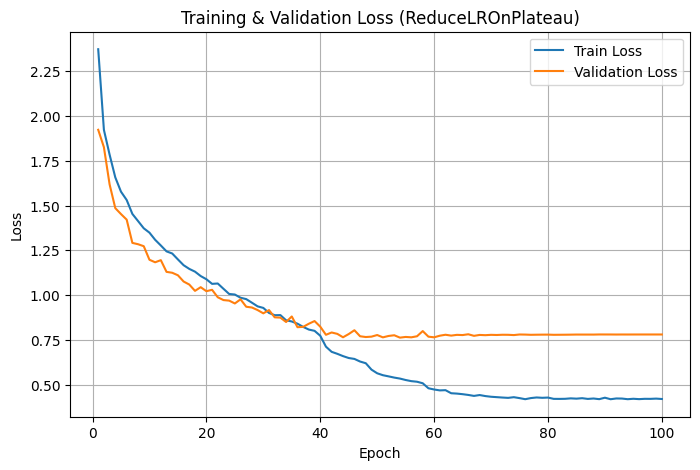

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

batch_size = 1024
epochs = 100
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = ViT_cifar10(config=ViTconfig).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)  # no weight decay

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
)

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_losses.append(train_loss)
    train_acc = correct / total * 100

    model.eval()
    val_loss_total, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss_total / total
    val_losses.append(val_loss)
    val_acc = correct / total * 100

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "/content/drive/MyDrive/vit_cifar10_12_100.pth")

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss (ReduceLROnPlateau)')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/vit_cifar10_loss_plot_12_100.png")
plt.show()
